# The best prophet of the future is the past. 
Lord Byron


In [16]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
import warnings

warnings.filterwarnings("ignore")

In [17]:
xl = pd.ExcelFile("GSPC_Extended.xlsx")
xl.sheet_names
df = xl.parse('GSPC_Extended')
df['Event Time'] = pd.to_datetime(df['Date'])
df = df[df['Event Time'] >= "2017/01/01"]
df = df.set_index('Event Time')
col = df.columns
for i in col:
    if i != 'MA147':
        df.drop([i], axis=1, inplace=True)

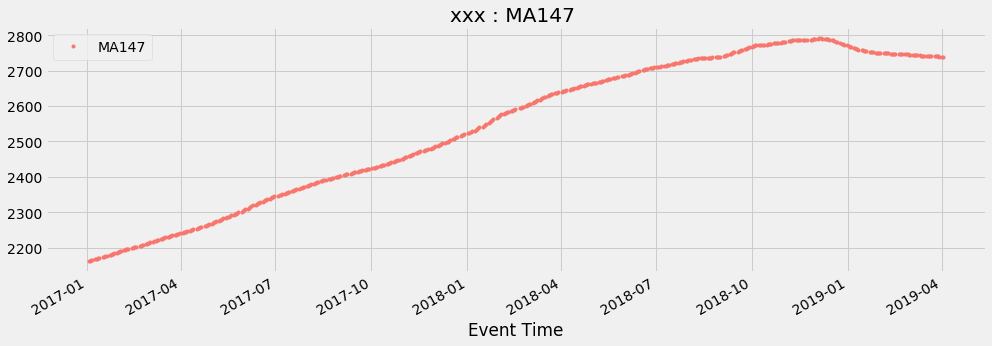

In [18]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='.', figsize=(15,5), color=color_pal[0], title='xxx : MA147 ')

In [19]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['minute'] = df['date'].dt.minute
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','minute','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [20]:
split_date = '2019/03/23 00:00:00 CEST'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

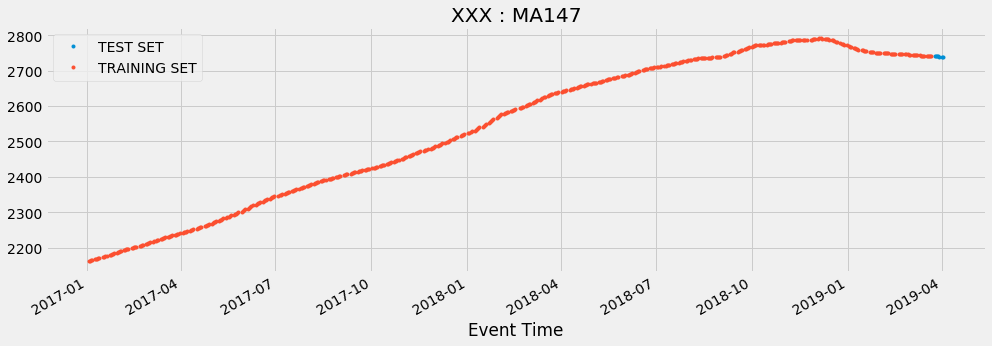

In [21]:
_ = df_test \
    .rename(columns={'MA147': 'TEST SET'}) \
    .join(df_train.rename(columns={'MA147': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='XXX : MA147', style='.')

In [22]:
# Setup and train model
model = Prophet()
model.fit(df_train.reset_index().rename(columns={'Event Time':'ds', 'MA147':'y'}))

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
# Predict on training set with model
df_test_fcst = model.predict(df=df_test.reset_index().rename(columns={'Event Time':'ds'}))

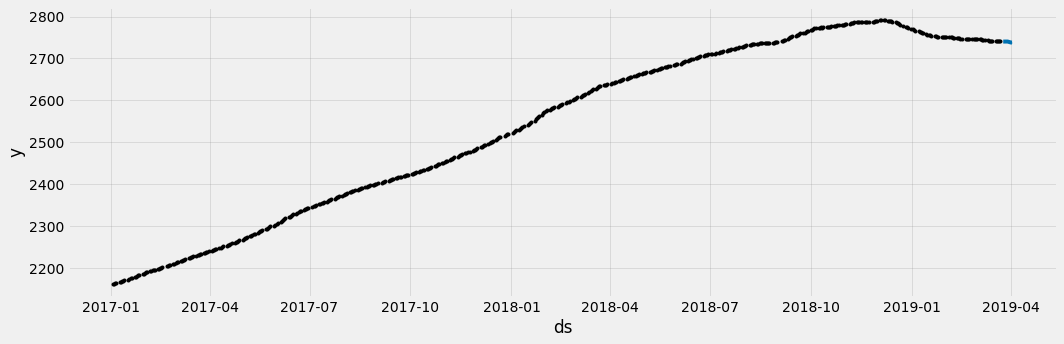

In [24]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(df_test_fcst, ax=ax)

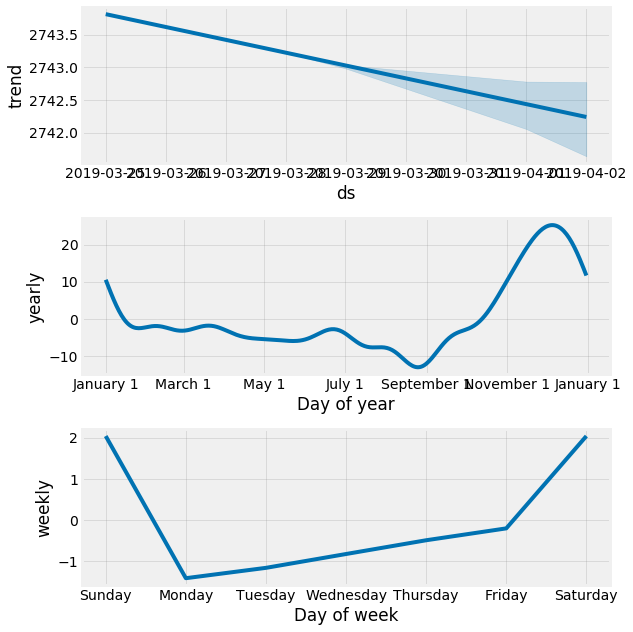

In [25]:
# Plot the components
fig = model.plot_components(df_test_fcst)

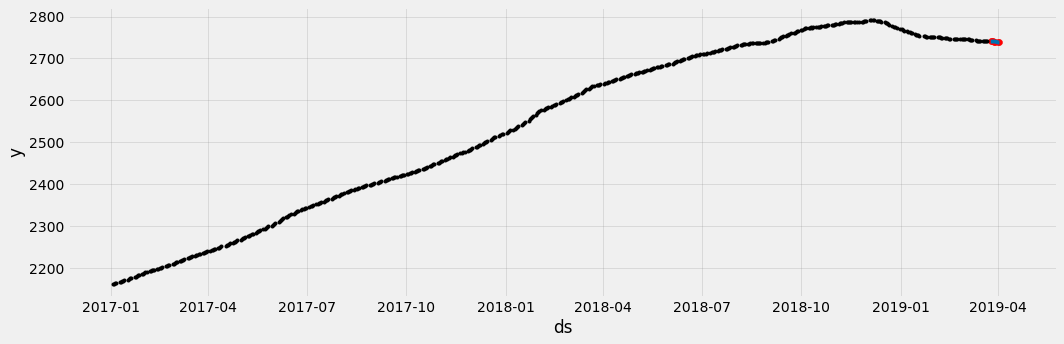

In [26]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_test.index, df_test['MA147'], color='r')
fig = model.plot(df_test_fcst, ax=ax)

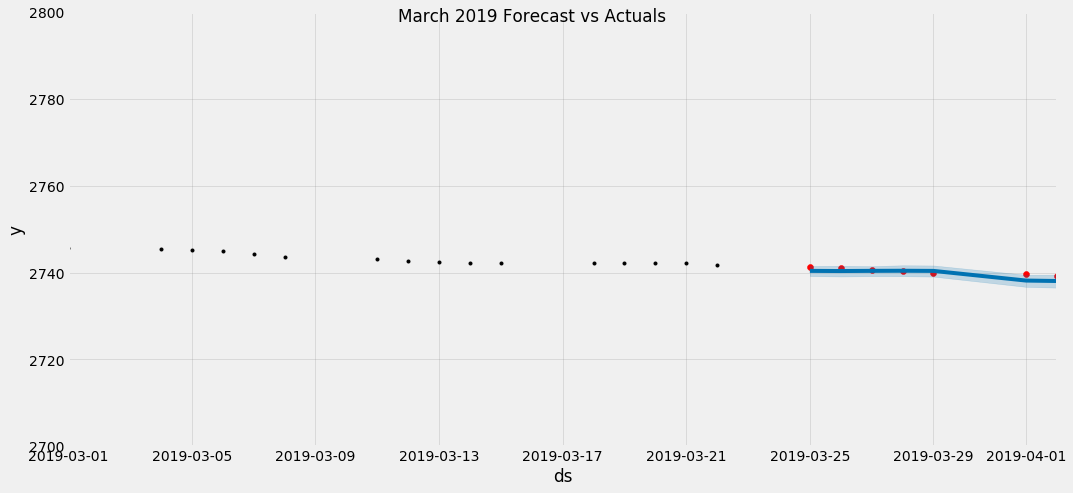

In [27]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(7)
f.set_figwidth(15)
ax.scatter(df_test.index, df_test['MA147'], color='r')
fig = model.plot(df_test_fcst, ax=ax)
ax.set_xbound(lower='2019-03-01', upper='2019-04-2')
ax.set_ylim(2700, 2800)
plot = plt.suptitle('March 2019 Forecast vs Actuals')

In [28]:
mean_squared_error(y_true=df_test['MA147'],
                   y_pred=df_test_fcst['yhat'])

0.77145743097875941

In [29]:
mean_absolute_error(y_true=df_test['MA147'],
                   y_pred=df_test_fcst['yhat'])

0.75330080811883293

In [30]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=df_test['MA147'],
                   y_pred=df_test_fcst['yhat'])

0.027491574139665964